<center><h1>QBUS6840 - Predictive Analytics </h1></center>

# Tutorial 5 - Time Series Decomposition II
 
### Objectives:

- Learn how to decompose time series data into trend and seasonal components **sequentially**. Learn how to forecast with the estimated trend and seasonal components.
- Learn how to model the trend and seasonal components **simultaneously** using multiple linear regression with seasonal dummy variables.

In the previous tutorial, we have learnt how to use moving average to smooth time series and make forecasts for the out-of-sample data. In this week, we will learn how to implement the time series decomposition approach, which is another commonly used forecasting technique in predictive modelling.

In general, time series components, e.g. trend, seasonality, etc., can be decomposed **sequentially** or **simultaneously**. In the sequential decomposition approach, the components are estimated sequentially and dependently, e.g. we estimate the trend component first and use the estimated trend to estimate the seasonal component. For example, the time series decomposition using the sequential approach normally inludes following steps: 

**Step 1**: Estimate the initial trend-cycle component $\overline{T}_t$ and compute the de-trend series.

**Step 2**: Given the de-trend series, estimate the normalized seasonal index $\overline{S}_t$ and the seasonal component $\widehat{S}_t$.
- The estimated seasonal component $\widehat{S}_t$ is obtained by concatenating the normalized seasonal indices.
- Remove the seasonal component from the original time series to obtain the seasonally adjusted data $\widetilde{Y}_t$.

**Step 3**: Given the seasonally adjusted data $\widetilde{Y}_t$, re-estimate the trend-cycle component $\widehat{T}_t$.

**Step 4**: Combine the forecast values of the trend-cycle $\widehat{T}_t$ and seasonal $\widehat{S}_t$ components to make the final forecasts (if we want to forecast).

<br />

**Note:** The above steps are the simplified version of the time series decomposition shown in the lecture 4, where we also discuss how to estimate the cycle and irregular components separately. The estimation for the cycle and irregular components will be assigned as the tutorial tasks.

Alternatively, it is also possible to estimate time series components simultaneously using a single multiple linear regression model with additional dummy variables to capture the seasonal effects at different seasonal indexes. This is the main idea of the simultaneous decomposition approach. 

In this tutorial, we will implement the time series decomposition technique using both sequential and similtaneous approaches.

## 1. Load external libraries and read the AirPassenger data

Create a new Jupyter Notebook called "Tutorial_05.ipynb" and download the ***AirPassenger.csv*** file from Canvas. Let's begin our script by importing necessary libraries:

In [1]:
# Import some external libraries
import pandas as pd                # For data manipulation
import matplotlib.pyplot as plt    # For visualization
import numpy as np                 # For linear algebra

Then read the data file into a `DataFrame` object and use the `Month` column as the index of the `DataFrame` and plot the time seres data

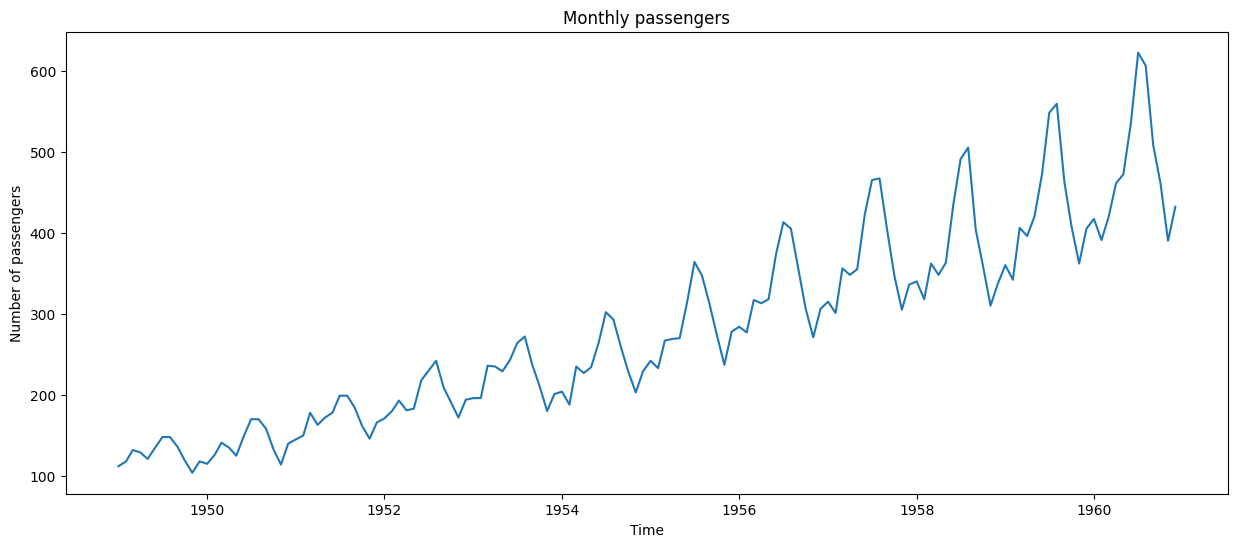

In [2]:
# Read data from a csv file
data = pd.read_csv('AirPassengers.csv')       
data['Month'] = pd.to_datetime(data['Month']) # Convert the data in the Month column to datetime
data.set_index('Month', inplace=True)         # Indexing the DataFrame by the Month column
data.head()                                   # See the first 5 rows

# Extract Passengers column
ts = data['Passengers']

# Plot number of passengers over time
plt.figure(figsize=(15,6))         
plt.plot(ts.index,ts)
plt.xlabel('Time')
plt.ylabel('Number of passengers')
plt.title('Monthly passengers')
plt.show()

We can see that the seasonal variation of the time series data increases with the trend. If we want to use the decomposion approach to model this type of data, a multiplicative model is more suitable (see lecture 4). However, in general, estimating additive models is easier than multiplicatie ones. Then one way to work around is to apply the log transformation to the orgininal time series, and then we can fit an additive model to the log-transformed series. As a by-product, the log transformation also helps to reduce the varitation of the data points over the trend. 

Now, we use the `log()` function of numpy to transform the air passenger data to log scale and plot the new time series.

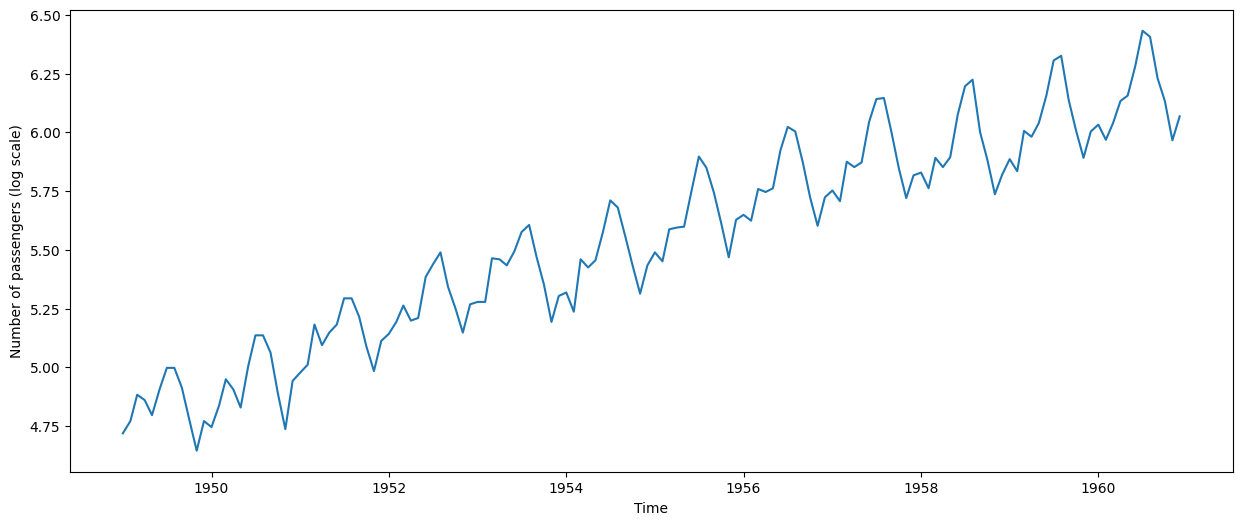

In [3]:
# Apply log transformation to all observations
ts_log = np.log(ts) 

# Plot the log-transformed series
plt.figure(figsize = (15,6))
plt.plot(ts.index, ts_log)
plt.xlabel('Time')
plt.ylabel('Number of passengers (log scale)')
plt.show()
# we need to do exponentioal to get rid of the log part


We can observe that the seasonal variation of the new time series is more stable over time. Then using an additive model to decomposte the new time series is more appropriated for transformed data.   

**Note:** The selection of decomposition type is important. Basically, we have 2 main decomposition types: additive and multiplicative:
- If the seasonal variation is proportional to the trend, i.e.,  the "gap" between the seasonal peak (rise) and valley (fall) is increasing along the trend, then we should use **multiplicative** model.
- Otherwise we should use **additive** model.
- We can apply the log transform to the time series to convert a multiplicative model into an additive model.

The key takeaway here is that you can fit a multiplicative model on the original (AirPassenger) data or an additive model on the log-transformed data. 

## 2. Model time series components sequentially

### 2.1. Step 1: Initially estimate the trend-cycle component by moving average

As discussed in the previous section, we choose the additive decomposition for the log-transformed data. To simplify the decomposition process, in this tutorial we will combine the trend and cycle components and obtain $\widehat{T}_t \approx \widehat{T_t + C_t}$ as the final estimation for the trend-cycle component. However, it is also possible to model the cycle  component separately (see lecture 4) and we will leave this additional step as the tutorial tasks. In many applications, using the trend and seasonal components is sufficient to obtain good forecast results.  

In Step 1, to calculate the ***initial*** estimation trend-cycle estimate, we need to do **Moving Average** to remove the seasonal fluctuation. For example, for the series with seasonal period `M`, we should do a `CMA-M`. Denote by $\overline{T}_t$ the initial estimation for the trend-cycle component, we have:

$$
\widehat{T}_t \approx \widehat{T_t + C_t} = \text{Moving Average}(Y_t)
\tag{1}
$$

Once we decide the decomposition method, which is an addictive model, the next step is to estimate the seasonal component. For additive decomposition, we have:

$$
S_t + R_t = Y_t - (T_t+C_t)
\tag{2}
$$

Given the initial estimation for the trend-cycle component $\widehat{T}_t$, we then subtract the initial trend from the original series to obtain the de-trended series and name this series as `ts_res` in the Python implementation. This `ts_res` series can be seen as the approximation for the $S_t + R_t$ component in (2). In the next section, we will use this de-trend series to fine-tune the estimation for the seasonal component. 

**Note:** In our dataset, we can observe the data has a yearly pattern. This means the seasonal period of data is `M=12` months (which is visually identified).

To calculate the initial trend-cycle estimate, we need to do center moving average smoothing to remove seasonal fluctuation. For even periods of seasonal peak, we must do a CMA-M which is essentially a `2xM-MA` (recall lecture 3), where `M` is the period. In this case the period is `M=12`, so we must do a `2x12-MA`.

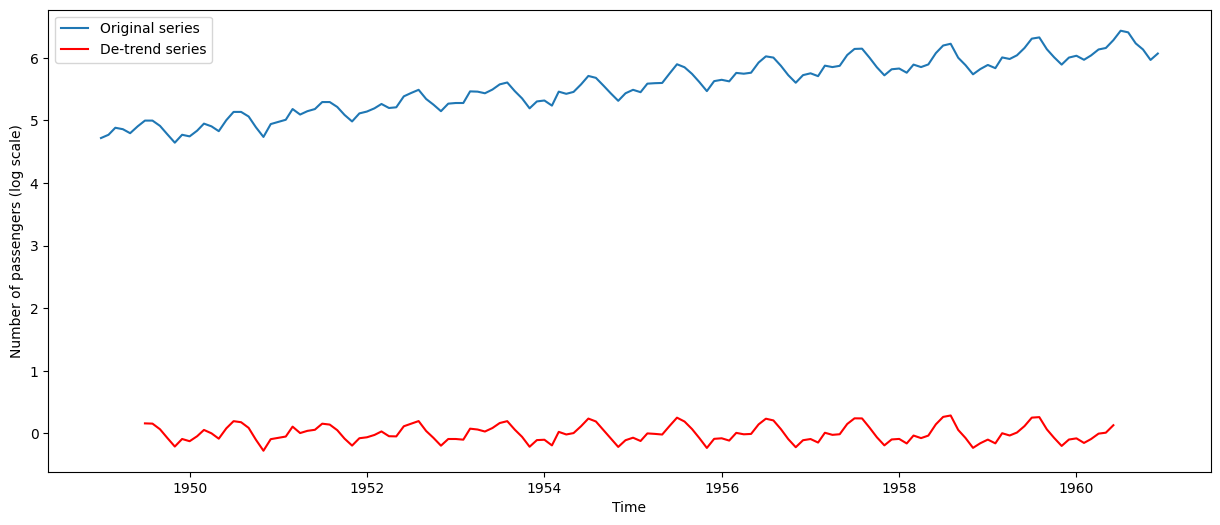

In [4]:
# Apply CMA-M with M=12 to initially estimate the trend
# Shift the new series to equalize (symmetrize) the number of missing values on both sides
Trend_init = ts_log.rolling(12,center=True).mean().rolling(2,center=True).mean().shift(-1)
# m12 等於我們透過去年的同月來預測未來今年同一個月的結果



# Subtract the initial trend from the original series to obtaibed the de-trend series
ts_res = ts_log - Trend_init

# Plot the de-trended and original series
plt.figure(figsize = (15,6))
plt.plot(ts_log.index,ts_log,label="Original series")
plt.plot(ts_log.index,ts_res,'r-',label="De-trend series")
plt.xlabel('Time')
plt.ylabel('Number of passengers (log scale)')
plt.legend()
plt.show()

<div style="margin-bottom: 0px;"><img width=20 style="display: block; float: left;  margin-right: 20px;" src="question-mark-button.png"> <h3 style="padding-top: 0px;">Question </h3></div>

- How many missing values on each side of the `Trend` series without applying `.shift(-1)`?  
- Why do we apply `.shift(-1)` after doing `CMA-(2k)` to initially estimate the Trend?

Now, we will use the de-trend series `ts_res`, which is the red line in the above figure to estimate the seasonal component. 

### 2.2. Step 2: Estimate the seasonal component from the de-trend series

In the previous section, we have obtained the de-trend series `ts_res` and we can use this de-trend series as the approximation for the seasonality and remainder component $S_t + R_t$. In this section, it is useful to combine $S_t$ and $R_t$ to a single seasonal component or we can even assume that we will ignore the remainder component $R_t$ to simplify the decomposition process. However, it is also possible to model the remainder component separately as shown in lecture 4. We will leave this additional step as the tutorial task instead. 

By definition, we assume that the season components are relatively unchanged throughout the dataset, e.g. 

$$
S_t = S_{t+M},
\tag{3}
$$ 

where $M$ is the seasonal period. More specifically, we can say that the seasonal values at the same seasonal indices are equal and hence the seasonal component can be presented by $M$ seasonal indices $\{\overline{S}_1,...,\overline{S}_M\}$ which are repeated over all seasons. Then to model the seasonal component of the time series, we will estimate the (normalized) seasonal indices $\{\overline{S}_1,...,\overline{S}_M\}$ and replicate these values over all seasons. 

The first step to estimate the seasonal indices is to take the average of the monthly values of the de-trend series `ts_res`. It is useful to think of the values at the same month index of the de-trend series are samples of the corresponding seasonal index. For example, the values of the de-trend series at Jan are samples of the seasonal index 1 and so on. Then by taking the average of the values having the same month indices of the de-trend series, we can get the estimation for the corresponding (unnormalized) seasonal indices.     

To do this, we need to replace the `NaN` components with some numerical values. For example, a simple choice is to replace these missing values by zeros. Although this is not a good strategy, but simple enough to demonstrate the concept and algorithm. We then reshape the de-trend the data into a matrix (2D array) whose number of columns is the same as the seasonal period $M=12$, e.g. each column contains the data of the corresponding month. Finally we will have a matrix of 12 rows (12 years) and 12 columns (12 seasonal indices) and we will take the average of columns (column mean)
to obtain the (unormalized) seasonal indices $\overline{s}_m$, $m=1,...,M$.

In [5]:
# Replace missing values in the ts_res by zeros
ts_res_zero = np.nan_to_num(ts_res)

# Reshape the de-trended series to a table. 
# A column contains data in a particular month of 12 years.
# For example, column 1 contains number of passengers in January of 12 years.
monthly_S = np.reshape(ts_res_zero, (12,12))

# Calculate column averages (Average number of passengers in 12 months of 12 years)
monthly_avg = np.mean(monthly_S[1:11,:], axis=0)
# ts_res_zero
# monthly_avg

# 把之前每一個月來做平均

In [6]:
ts_res_zero

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.59932422e-01,  1.56097816e-01,
        6.60589591e-02, -7.21149478e-02, -2.10096940e-01, -8.92696617e-02,
       -1.24907895e-01, -4.51069632e-02,  5.53490906e-02,  9.82071040e-04,
       -8.44386861e-02,  8.02453264e-02,  1.95315815e-01,  1.78392690e-01,
        8.82152426e-02, -1.01593124e-01, -2.76896144e-01, -9.21612523e-02,
       -7.10425838e-02, -5.02665645e-02,  1.07971395e-01,  5.37188210e-03,
        4.05888506e-02,  5.74715266e-02,  1.55023002e-01,  1.40554195e-01,
        5.12172862e-02, -8.38576974e-02, -1.94794849e-01, -7.74429816e-02,
       -6.22457966e-02, -2.51361433e-02,  3.11375532e-02, -4.52254206e-02,
       -4.79265052e-02,  1.13759145e-01,  1.55163330e-01,  1.96788043e-01,
        3.82554259e-02, -7.10649855e-02, -1.96065784e-01, -8.95688614e-02,
       -8.95805352e-02, -1.00194457e-01,  7.54147622e-02,  6.17805298e-02,
        2.98733909e-02,  

In [7]:
# len(monthly_S) = 12
monthly_S

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.59932422e-01,  1.56097816e-01,  6.60589591e-02,
        -7.21149478e-02, -2.10096940e-01, -8.92696617e-02],
       [-1.24907895e-01, -4.51069632e-02,  5.53490906e-02,
         9.82071040e-04, -8.44386861e-02,  8.02453264e-02,
         1.95315815e-01,  1.78392690e-01,  8.82152426e-02,
        -1.01593124e-01, -2.76896144e-01, -9.21612523e-02],
       [-7.10425838e-02, -5.02665645e-02,  1.07971395e-01,
         5.37188210e-03,  4.05888506e-02,  5.74715266e-02,
         1.55023002e-01,  1.40554195e-01,  5.12172862e-02,
        -8.38576974e-02, -1.94794849e-01, -7.74429816e-02],
       [-6.22457966e-02, -2.51361433e-02,  3.11375532e-02,
        -4.52254206e-02, -4.79265052e-02,  1.13759145e-01,
         1.55163330e-01,  1.96788043e-01,  3.82554259e-02,
        -7.10649855e-02, -1.96065784e-01, -8.95688614e-02],
       [-8.95805352e-02, -1.00194457e-01,  7.5414762

In [8]:
monthly_avg

array([-0.08740625, -0.11156185,  0.02802349, -0.0148985 , -0.01193961,
        0.11290597,  0.21495259,  0.20840161,  0.06376184, -0.07653914,
       -0.21737273, -0.10237186])

<div style="margin-bottom: 0px;"><img width=20 style="display: block; float: left;  margin-right: 20px;" src="question-mark-button.png"> <h3 style="padding-top: 0px;">Question </h3></div>

Before you copy the above code, think about the following questions:
1. What is the size of `monthly_S` (the seasonal index)?
2. What is the meaning of `1:11`?
3. If we don't want to use 0 to replace `NaN`, what are other suggestions? 

Then due to the unidentification issue, we should normalize our data in order to obtain a unique solution for the seasonal indices. For additive decomposition, we should make the mean of seasonal index equal to zero. Therefore, we should take the mean of the seasonal index out of the original seasonal indices to obtain the normalized seasonal indices.

$$
\overline{S}_m = \overline{s}_m - \frac{1}{M}\sum_{m=1}^M \overline{s}_m, m=1,...,M.
\tag{4}
$$


In [9]:
# Normalize the seasonal index
seasonal_idx = monthly_avg.mean()
seasonal_idx_normalized = monthly_avg - seasonal_idx
print(seasonal_idx_normalized.mean())
#算出每一個月的平均值

-6.938893903907228e-18


<div style="margin-bottom: 0px;"><img width=20 style="display: block; float: left;  margin-right: 20px;" src="question-mark-button.png"> <h3 style="padding-top: 0px;">Question </h3></div>

- How to obtain normalized seasonal indices for the multiplicative decomposition model?

The seasonal component of the time series is then obtained by replicating the normalized seasonal indices $\{\overline{S}_1,...,\overline{S}_M\}$ over all seasons (12 years). Once the seasonal component $\widehat{S}_t$ is estimated, we can eliminate the seasonality from the original data to obtain the **seasonally adjusted data**. 

$$\widetilde{Y}_t = Y_t - \widehat{S}_t$$

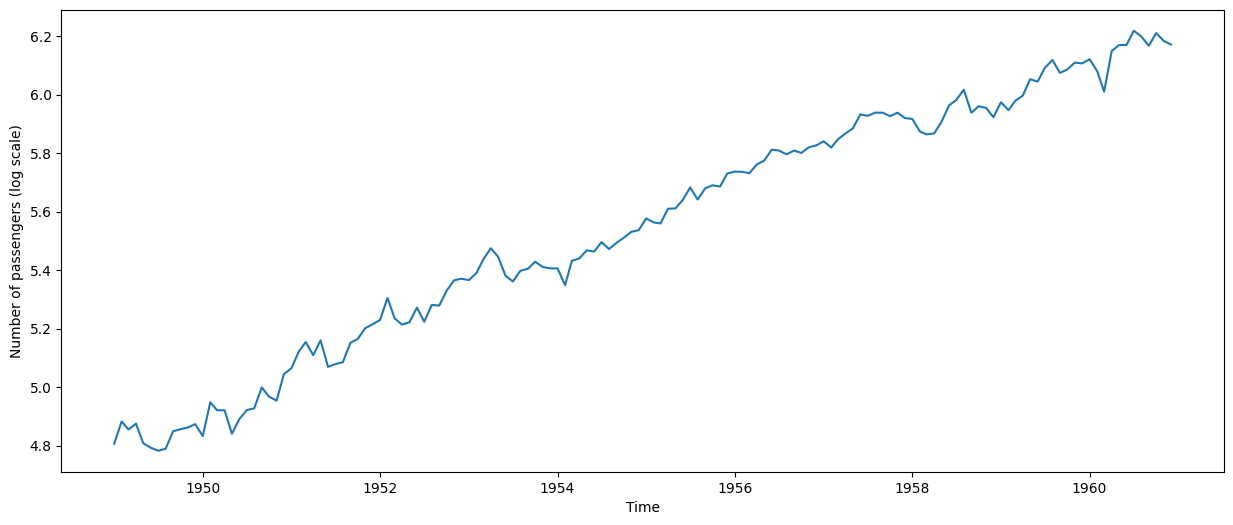

In [10]:
# Replicate the normalized seasonal index array 12 times 
# to obtain the final estimation of the seasonal component
seasonal = np.tile(seasonal_idx_normalized, 12)
# 把每個月的平均值nomalize化
# Subtract the seasonal average from the original data 
# to obtain the seasonal adjusted data
seasonally_adjusted = ts_log - seasonal
# print(ts_log)
# print(seasonal)
# print(seasonally_adjusted)
# 把標準化的資料夾或減上去原本log過後的資料
plt.figure(figsize = (15,6))
plt.plot(ts.index, seasonally_adjusted)
plt.xlabel('Time')
plt.ylabel('Number of passengers (log scale)')
plt.show()
# 把seasonal 去掉過後可以更精準預測

Plot all the original series and the components

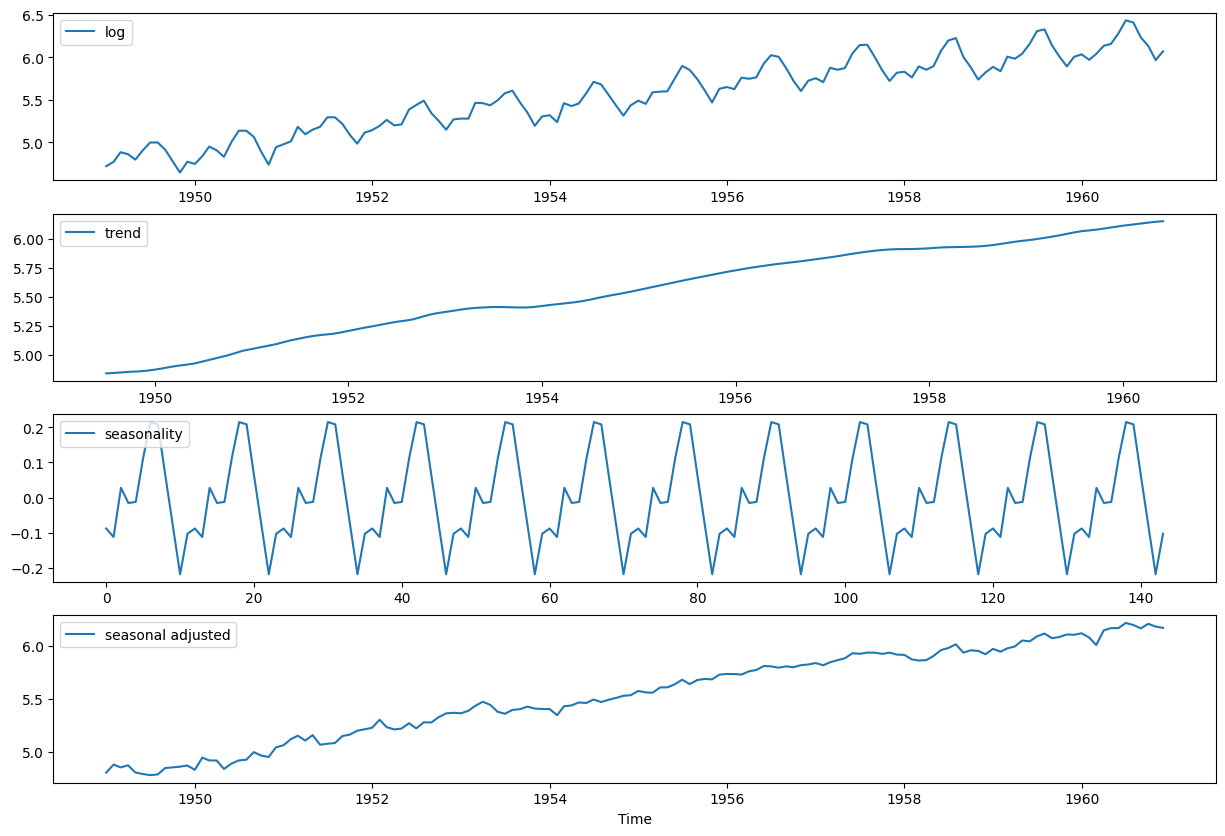

In [11]:
# Plot the seasonally adjusted data:
fig, ax = plt.subplots(4, 1,figsize=(15,10))
ax[0].plot(ts_log)
ax[1].plot(Trend_init)
ax[2].plot(seasonal)
ax[3].plot(seasonally_adjusted)
ax[0].legend(['log'], loc=2)
ax[1].legend(['trend'], loc=2)
ax[2].legend(['seasonality'], loc=2)
ax[3].legend(['seasonal adjusted'], loc=2)
plt.xlabel('Time')
plt.show()

Finally, we can use the new time series without seasonality (seasonally adjusted data $\widetilde{Y}_t$) to obtain more accurate trend-cycle estimation. This will be shown in the next section. 


### 2.3.  Step 3: Re-estimate the trend-cycle component using the seasonally adjusted data

We can re-estimate the trend-cycle component $\widehat{T}_t$ based on the seasonally adjusted data $\widetilde{Y}_t$ obtained in the previous step. There are many ways to update the trend-cycle component $\widehat{T}_t$. If we want to simply smooth the noisy seasonally adjusted data, we can use a moving average to regenerate the final trend-cycle component.

In this tutorial, we are interested in producing forecast values for the number of air passenger in the next months, then it is useful to fit a linear regression model on the trend and use the fitted model to make forecasts for the trend. Finally we can use the trend forecasts, together with the normalized seasonal indices, to make forecasts for the number of air passengers in upcoming months. 

To fit a linear regression model on a given dataset, we will use the `LinearRegression` class of scikit-learn, which is a popular library for machine learning algorithms. The steps of fitting a linear regression model on seasonally adjusted data are as follows:
- Create a `LinearRegression` model object with default or custom arguments.
- Call `.fit()` method and passing training data $(X,y)$ as the input. $X$ must be a 2D array.  

**Note:** In this tutorial, we use a simple linear regression model for the final trend as:

$$
T_t = \beta_0 + \beta_1 t + \varepsilon_t , \;\;\; \varepsilon_t \sim \mathcal{N}(0,\sigma^2)
\tag{5}
$$

where the coefficients $\beta_0$ and $\beta_1$ are estimated by fitting the seasonally adjusted series on time. $t$ and $T_t$ in (5) are corresponding to the $X$ and $y$ inputs of the `fit()` method of `LinearRegression` object.

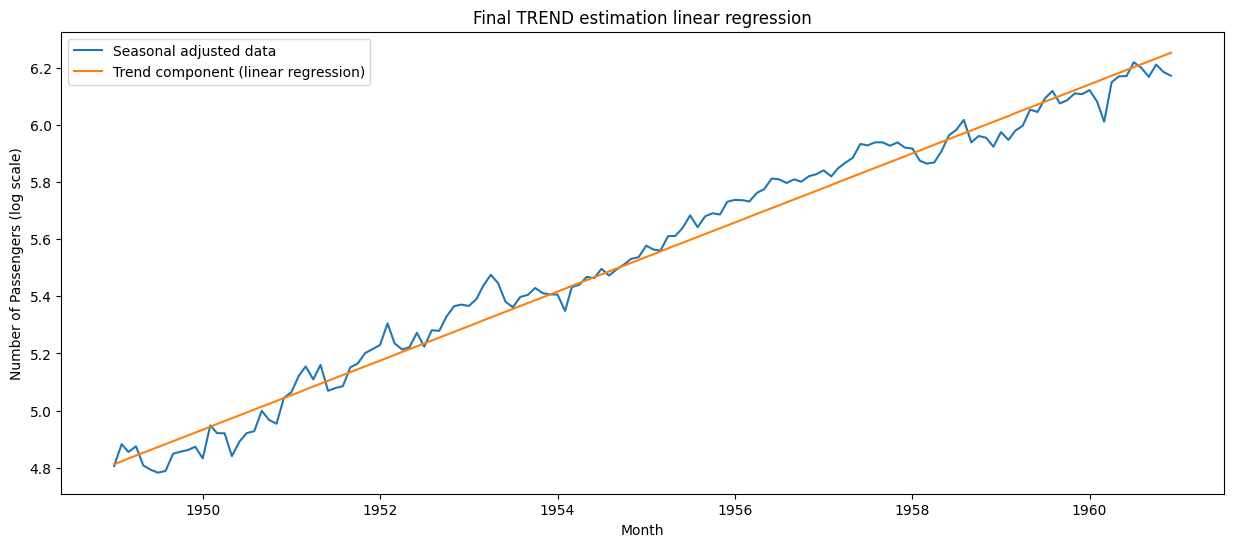

In [12]:
# Import library for quicky performing linear regression
from sklearn.linear_model import LinearRegression 

# Prepare training data
X = np.linspace(1, len(seasonally_adjusted), len(seasonally_adjusted)) # Create time indexes from 1 to T as the input
X = np.reshape(X, (len(seasonally_adjusted), 1))                       # Transform X to 2D array (matrix)
y = seasonally_adjusted.values    

# Create a LinearRegression object
lm = LinearRegression()   

# Train the linear regression model on training data (X,y)
lm.fit(X, y)

# Obtain estimation for the trend using the trained linear model
X_fitting = np.reshape(np.arange(len(seasonally_adjusted)), (len(seasonally_adjusted),1))
trend_linear = lm.predict(X_fitting)

# Now plot the seasonally adjusted data and the corresponding regression line
plt.figure(figsize=(15,6))
plt.plot(ts.index,seasonally_adjusted)
plt.plot(ts.index,trend_linear)
plt.title('Final TREND estimation linear regression')
plt.xlabel('Month')
plt.ylabel('Number of Passengers (log scale)')
plt.legend(['Seasonal adjusted data','Trend component (linear regression)'])
plt.show()

<div style="margin-bottom: 0px;"><img width=20 style="display: block; float: left;  margin-right: 20px;" src="docs.png"> <h3 style="padding-top: 0px;">Documentation - LinearRegression class in scikit-learn </h3></div>

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

Now you have successfully extract the major components (trend-cycle, and seasonality) from the transformed AirPassenger data.

### 2.4.  Step 4: Forecasting with the estimated trend and seasonal components

Now we are ready to make forecasts with the decomposition approach, given the final estimation of the trend and seasonal components. Since we decomposte the time series components using an additive model, the one-step-ahead forecast $\widehat{Y}_{T+1|T}$ can be computed as

$$
\widehat{Y}_{T+1|T} = \widehat{T}_{T+1|T} + \widehat{S}_{T+1|T}
\tag{6}
$$

with $\widehat{T}_{T+1|T}$ and $\widehat{S}_{T+1|T}$ one-step-ahead forecasts for the trend and seasonal components, respectively. The one-step-ahead forecast for the trend can be computed easily using the fitted regression model in the previous section :

$$
\widehat{T}_{T+1|T} =\beta_0 + \beta_1  (T+1)
\tag{7}
$$

and the one-step-ahead forecast for the seasonality is simply the corresponding normalized seasonal index:

$$
\widehat{S}_{T+1|T} = \overline{S}_1
\tag{8}
$$

if $T=km$ with $k$ a positive integer (why?). 

**Note:** We call the `predict()` method of the fitted linear model `lm` to implement the equation (7). Similar to the `fit()` method, the `predict()` method also requires 2D input data. 

In [13]:
# Forecast the trend component in Jan 1961
Trend_forecast = lm.predict(np.array([[len(ts)+1]]))
# len(ts) 是我們所有現在有的所有資料 後面加上的數字就是我們要預測的月份
# Forecast the seasonal component in Jan 1961
Seasonal_forecast = seasonal_idx_normalized[0]
#因為是Jan所以是0 如果是二月的話就是1


# Get the sum of the trend and seasonal forecasts
Y_forecast = Trend_forecast + Seasonal_forecast
print("Jan 1961 by prediction is "+str(Y_forecast))
#把trend and seasonal 加上去

Jan 1961 by prediction is [6.18399173]


<div style="margin-bottom: 0px;"><img width=20 style="display: block; float: left;  margin-right: 20px;" src="question-mark-button.png"> <h3 style="padding-top: 0px;">Question </h3></div>

- Is `Y_forecast` the final forecast value for the number of passenger in Jan 1962? if not, why? **Hint:** are the trend and seasonal components estimated on the origial scale?


## 3. Model time series components simultaneously will talk about this next week


In Lecture 4, we introduce a method of using dummy variables to fit some patterns in time series. For seasonal patterns, we can use dummy variables to differentiate the seasonal effects at different seasonal indices. In the previous example, we build a **simple** linear regression model for the trend-cycle component where the only predictor is time $t$, e.g. $T_t = \beta_0 + \beta_1 t + \varepsilon_t$.

If we want to simultaneously model the trend and seasonal components, we can define a **multiple** linear regression model as:

$$
Y_t = \beta_0 + \beta_1 t + \beta_2 d_{2,t} + \beta_3 d_{3,t} + ... + \beta_{12} d_{12,t} + \varepsilon_t, \;\;\; \varepsilon_t \sim \mathcal{N}(0,\sigma^2)
\tag{9}
$$

where $d_{j,t}$ denotes the dummy variable corresponding to the seasonal index $j\ge 2$.

**Note:** Notice that only $m-1$ dummy variables are needed to code $m$ categories (why?).

To fit the multiple linear regression model in (9), we need to prepare the training data including numerical values for the seasonal dummy variables $d_{2,t},...,d_{12,t}$ at all time steps $t=1,...,T$. For example, the values of dummy variables at each time step can be determined as:  
- When $t$ is a January, e.g. $t=1, 13, 25, ...$, we have:
$$d_{2,t}=d_{3,t}=...=d_{12,t} = 0$$
- When $t$ is a February, e.g. $t=2, 14, 26,...$, we have:
$$d_{2,t}=1 \; \text{and} \; d_{j \ne 2,t} = 0$$
- When $t$ is a March, e.g. $t=3, 15, 27,...$,   we have:
$$d_{3,t}=1 \; \text{and} \; d_{j \ne 3,t} = 0$$
- Apply the same rule to prepare data for $d_{4,t},...,d_{12,t}$.

Finally, the training data will have the format shown in the following table where each row corresponds to an observation or data point at time $t$. We then train a multiple linear regression model for $Y_t$, i.e. output/dependent variable, and $t,d_{2,t},...,d_{12,t}$, i.e. input/predictors/features/independent variables. 

<img width=600px src="Seasonal_dummy.png">

一個月一個月作切換，所以一個循環也是12個月。

### 3.1. Prepare seasonal dummy variables

We create a new categorical variable by assigning corresponding months for each time step.

In [14]:
# we start from January
seasons = []
for i in range(y.size):
    if i % 12 == 0:
        seasons = np.append(seasons, 'Jan')
    if i % 12 == 1:
        seasons = np.append(seasons, 'Feb')
    if i % 12 == 2:
        seasons = np.append(seasons, 'Mar')
    if i % 12 == 3:
        seasons = np.append(seasons, 'Apr')
    if i % 12 == 4:
        seasons = np.append(seasons, 'May')
    if i % 12 == 5:
        seasons = np.append(seasons, 'Jun')
    if i % 12 == 6:
        seasons = np.append(seasons, 'Jul')
    if i % 12 == 7:
        seasons = np.append(seasons, 'Aug')
    if i % 12 == 8:
        seasons = np.append(seasons, 'Sep')
    if i % 12 == 9:
        seasons = np.append(seasons, 'Oct')
    if i % 12 == 10:
        seasons = np.append(seasons, 'Nov')
    if i % 12 == 11:
        seasons = np.append(seasons, 'Dec')

<div style="margin-bottom: 0px;"><img width=20 style="display: block; float: left;  margin-right: 20px;" src="question-mark-button.png"> <h3 style="padding-top: 0px;">Question </h3></div>

- Check the data type and shape of the `seasons` variable. What are the values over there?

You note that the variable `seasons` contain string values such as `Jan, …, Dec`. They are so-called categorical values. Next we convert the `seasons` variable to dummy representation using the `get_dummy()` function of `Pandas`

In [15]:
dummies = pd.get_dummies(seasons, drop_first=True)
dummies.head()

,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,0


<div style="margin-bottom: 0px;"><img width=20 style="display: block; float: left;  margin-right: 20px;" src="question-mark-button.png"> <h3 style="padding-top: 0px;">Question </h3></div>

- What is the meaning of `drop_first=True`?
- Write down all the values in the first row which corresponding to Jan. What are values? 

You may note that the fourth row (corresponding to April) contains all $0$. This is because Python orders month names in alphabetic order. It really does not matter which month's dummy variable values are all $0$. The important thing is that each month is presented by its own unique set of dummy values.

### 3.2. Prepare the training data

In this example, we use all available data to train the model. If we are interested in examining the predictive performance of the current model, a train/test split step is needed.

In [16]:
X = np.linspace(1, len(ts_log), len(ts_log)) # Create time indexes for input variable t
y = ts_log # Values of the output variable Y_t

# dummies is a pandas DataFrame, we shall take values out by getting the attribute values of DataFrame objects
dummies_val = dummies.values

# Now we concatenate these dummy features (columns) to the time column to contruct the training (input) data
Xnew = np.hstack((X.reshape(len(X),1),dummies_val))

<div style="margin-bottom: 0px;"><img width=20 style="display: block; float: left;  margin-right: 20px;" src="question-mark-button.png"> <h3 style="padding-top: 0px;">Question </h3></div>

- Check the data types and shapes of the variables `Xnew`. What are the values you observe?

### 3.3. Fit  a multiple linear regression model on the training data

In [17]:
# Create linear regression object (model)
mlr = LinearRegression()

# Train the model using the training sets
mlr.fit(Xnew, y)

# The coefficients
print('Coefficients: \n', mlr.coef_)

# The intercept
print('Intercept: \n', mlr.intercept_)

Coefficients: 
 [ 0.0100688   0.21442105 -0.09822451 -0.09895827 -0.07690344  0.22371589
  0.11977356  0.03126885 -0.00237264 -0.21208951 -0.0683718   0.06978645]
Intercept: 
 4.803683812330508


### 3.4. Plot observed and fitted values

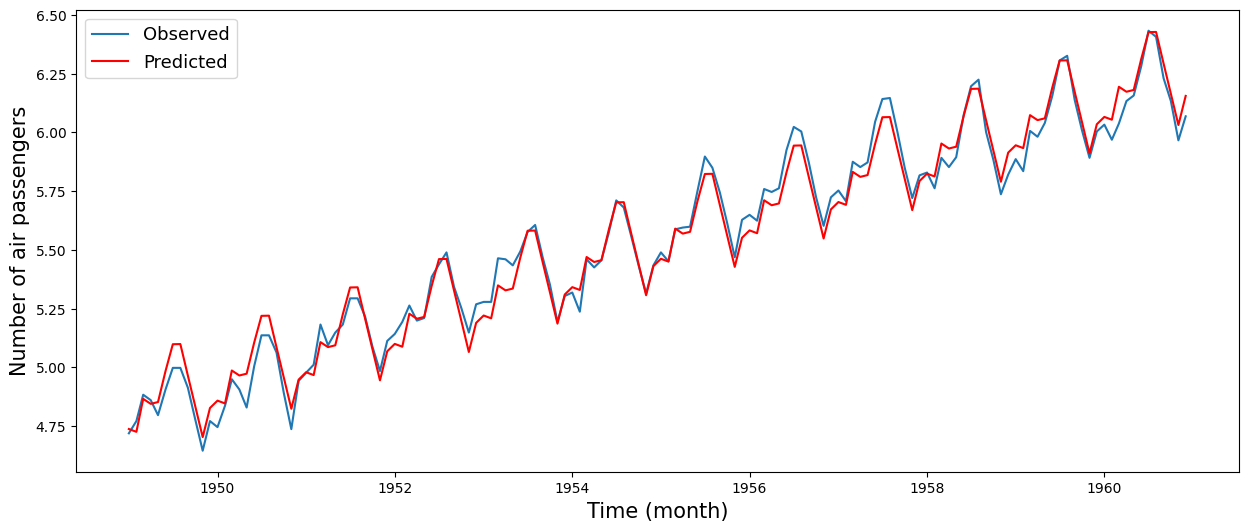

In [18]:
# Compute the fitted values (in-sample forecast)
Ypred = mlr.predict(Xnew)

# Visually compare the observed and fitted values
plt.figure(figsize=(15,6))
plt.plot(y.index,y, label='Observed')
plt.plot(y.index,Ypred, '-r', label='Predicted')
plt.xlabel('Time (month)',fontsize=15)
plt.ylabel('Number of air passengers',fontsize=15)
plt.legend(fontsize=13)
plt.show()

**Note:** The fitted values produced by the simultaneous decomposition approach are closed to observed data, indicating that the proposed model has a good in-sample performance (we also need some metrics to quantify this). However, a good in-sample performance does not inherently result in a good out-of-sample performance, i.e. predictive performance. To make any conclusions about the predictive performance of the model, we need to follow the validation process introduced in tutorial 03, e.g. using in-sample data for model estimation and out-of-sample data for measuring the predictive performance of the fitted model.    

# Tasks
1. Given the final estimation of the trend $\widehat{T}_t$ and sesonal $\widehat{S}_t$ components in Section 2, plot the observed and fitted values produced by the sequential decomposition approach.  
2. Given the final estimation of the trend $\widehat{T}_t$ and sesonal $\widehat{S}_t$ components in Section 2, estimate the cycle component $\widehat{C}_t$. 
3. Given the estimation of the trend, sesonal and cycle components, estimate the remainder component. 
4. In Section 2.4 (Step 4), how to make forecast for the trend if we use moving average in Step 3 (section 2.3).
5. Using the fitted model in section 3.3, produce the forecast value at $\widehat{Y}_{T+1|T}$. Which model make more accurate forecast for the number of air passengers at $T+1$, the model in section 2 or 3?